In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [2]:
pd.set_option('display.max_columns', 250)
df = pd.read_csv('./datasets/clean_train.csv')
df.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,overall_qual,overall_cond,year_built,year_remod/add,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,garage_yr_blt,garage_cars,garage_area,garage_qual,garage_cond,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_type,saleprice,street_Pave,bldg_type_2fmCon,bldg_type_Duplex,bldg_type_Twnhs,bldg_type_TwnhsE,house_style_1.5Unf,house_style_1Story,house_style_2.5Fin,house_style_2.5Unf,house_style_2Story,house_style_SFoyer,house_style_SLvl,roof_style_Gable,roof_style_Gambrel,roof_style_Hip,roof_style_Mansard,roof_style_Shed,foundation_CBlock,foundation_PConc,foundation_Slab,foundation_Stone,foundation_Wood,central_air_Y,garage_type_Attchd,garage_type_Basment,garage_type_BuiltIn,garage_type_CarPort,garage_type_Detchd,garage_type_NA,garage_finish_NA,garage_finish_RFn,garage_finish_Unf,paved_drive_P,paved_drive_Y
0,109,533352170,60,RL,68.0,13517,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,6,8,1976,2005,CompShg,HdBoard,Plywood,BrkFace,289.0,4,3,3,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,1976.0,2.0,475.0,TA,3,0,44,0,0,0,0,0,3,2010,WD,130500,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1
1,544,531379050,60,RL,43.0,11492,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,7,5,1996,1997,CompShg,VinylSd,VinylSd,BrkFace,132.0,4,3,4,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,1997.0,2.0,559.0,TA,3,0,74,0,0,0,0,0,4,2009,WD,220000,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1
2,153,535304180,20,RL,68.0,7922,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,5,7,1953,2007,CompShg,VinylSd,VinylSd,None,0.0,3,4,3,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,1953.0,1.0,246.0,TA,3,0,52,0,0,0,0,0,1,2010,WD,109000,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1
3,318,916386060,60,RL,73.0,9802,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,5,5,2006,2007,CompShg,VinylSd,VinylSd,None,0.0,3,3,4,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,2007.0,2.0,400.0,TA,3,100,0,0,0,0,0,0,4,2010,WD,174000,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
4,255,906425045,50,RL,82.0,14235,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,6,8,1900,1993,CompShg,Wd Sdng,Plywood,None,0.0,3,3,2,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,1957.0,2.0,484.0,TA,3,0,59,0,0,0,0,0,3,2010,WD,138500,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0


In [3]:
df = pd.get_dummies(df, columns=['ms_subclass', 'ms_zoning', 'lot_shape', 'land_contour', 'utilities', 'lot_config',
                                 'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'roof_matl', 'exterior_1st',
                                 'exterior_2nd', 'mas_vnr_type', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2',
                                 'heating', 'electrical', 'functional', 'sale_type',])

In [4]:
def ordinal_values(ordinal_cell):
    if ordinal_cell == 'NA':
        return 0
    elif ordinal_cell == 'Po':
        return 1
    elif ordinal_cell == 'Fa':
        return 2
    elif ordinal_cell == 'TA':
        return 3
    elif ordinal_cell == 'Gd':
        return 4
    else:
        return 5

In [5]:
df['bsmt_cond'] = df['bsmt_cond'].map(ordinal_values)
df['heating_qc'] = df['heating_qc'].map(ordinal_values)
df['kitchen_qual'] = df['kitchen_qual'].map(ordinal_values)
df['garage_qual'] = df['garage_qual'].map(ordinal_values)

In [6]:
df.head()

,id,pid,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,exter_qual,exter_cond,bsmt_qual,bsmt_cond,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating_qc,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,fireplaces,garage_yr_blt,garage_cars,garage_area,garage_qual,garage_cond,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,saleprice,street_Pave,bldg_type_2fmCon,bldg_type_Duplex,bldg_type_Twnhs,bldg_type_TwnhsE,house_style_1.5Unf,house_style_1Story,house_style_2.5Fin,house_style_2.5Unf,house_style_2Story,house_style_SFoyer,house_style_SLvl,roof_style_Gable,roof_style_Gambrel,roof_style_Hip,roof_style_Mansard,roof_style_Shed,foundation_CBlock,foundation_PConc,foundation_Slab,foundation_Stone,foundation_Wood,central_air_Y,garage_type_Attchd,garage_type_Basment,garage_type_BuiltIn,garage_type_CarPort,garage_type_Detchd,garage_type_NA,garage_finish_NA,garage_finish_RFn,garage_finish_Unf,paved_drive_P,paved_drive_Y,ms_subclass_20,ms_subclass_30,ms_subclass_40,ms_subclass_45,ms_subclass_50,ms_subclass_60,ms_subclass_70,ms_subclass_75,ms_subclass_80,ms_subclass_85,ms_subclass_90,ms_subclass_120,ms_subclass_150,ms_subclass_160,ms_subclass_180,ms_subclass_190,ms_zoning_A (agr),ms_zoning_C (all),ms_zoning_FV,ms_zoning_I (all),ms_zoning_RH,ms_zoning_RL,ms_zoning_RM,lot_shape_IR1,lot_shape_IR2,lot_shape_IR3,lot_shape_Reg,land_contour_Bnk,land_contour_HLS,land_contour_Low,land_contour_Lvl,utilities_AllPub,utilities_NoSeWa,utilities_NoSewr,lot_config_Corner,lot_config_CulDSac,lot_config_FR2,lot_config_FR3,lot_config_Inside,land_slope_Gtl,land_slope_Mod,land_slope_Sev,neighborhood_Blmngtn,neighborhood_Blueste,neighborhood_BrDale,neighborhood_BrkSide,neighborhood_ClearCr,neighborhood_CollgCr,neighborhood_Crawfor,neighborhood_Edwards,neighborhood_Gilbert,neighborhood_Greens,neighborhood_GrnHill,neighborhood_IDOTRR,neighborhood_Landmrk,neighborhood_MeadowV,neighborhood_Mitchel,neighborhood_NAmes,neighborhood_NPkVill,neighborhood_NWAmes,neighborhood_NoRidge,neighborhood_NridgHt,neighborhood_OldTown,neighborhood_SWISU,neighborhood_Sawyer,neighborhood_SawyerW,neighborhood_Somerst,neighborhood_StoneBr,neighborhood_Timber,neighborhood_Veenker,condition_1_Artery,condition_1_Feedr,condition_1_Norm,condition_1_PosA,condition_1_PosN,condition_1_RRAe,condition_1_RRAn,condition_1_RRNe,condition_1_RRNn,condition_2_Artery,condition_2_Feedr,condition_2_Norm,condition_2_PosA,condition_2_PosN,condition_2_RRAe,condition_2_RRAn,condition_2_RRNn,roof_matl_CompShg,roof_matl_Membran,roof_matl_Tar&Grv,roof_matl_WdShake,roof_matl_WdShngl,exterior_1st_AsbShng,exterior_1st_AsphShn,exterior_1st_BrkComm,exterior_1st_BrkFace,exterior_1st_CBlock,exterior_1st_CemntBd,exterior_1st_HdBoard,exterior_1st_ImStucc,exterior_1st_MetalSd,exterior_1st_Plywood,exterior_1st_Stone,exterior_1st_Stucco,exterior_1st_VinylSd,exterior_1st_Wd Sdng,exterior_1st_WdShing,exterior_2nd_AsbShng,exterior_2nd_AsphShn,exterior_2nd_Brk Cmn,exterior_2nd_BrkFace,exterior_2nd_CBlock,exterior_2nd_CmentBd,exterior_2nd_HdBoard,exterior_2nd_ImStucc,exterior_2nd_MetalSd,exterior_2nd_Plywood,exterior_2nd_Stone,exterior_2nd_Stucco,exterior_2nd_VinylSd,exterior_2nd_Wd Sdng,exterior_2nd_Wd Shng,mas_vnr_type_BrkCmn,mas_vnr_type_BrkFace,mas_vnr_type_None,mas_vnr_type_Stone,mas_vnr_type_Unknwn,bsmt_exposure_Av,bsmt_exposure_Gd,bsmt_exposure_Mn,bsmt_exposure_No,bsmtfin_type_1_ALQ,bsmtfin_type_1_BLQ,bsmtfin_type_1_GLQ,bsmtfin_type_1_LwQ,bsmtfin_type_1_Rec,bsmtfin_type_1_Unf,bsmtfin_type_2_ALQ,bsmtfin_type_2_BLQ,bsmtfin_type_2_GLQ,bsmtfin_type_2_LwQ,bsmtfin_type_2_Rec,bsmtfin_type_2_Unf,heating_GasA,heating_GasW,heating_Grav,heating_OthW,heating_Wall,electrical_FuseA,electrical_FuseF,electrical_FuseP,electrical_Mix,electrical_SBrkr,functional_Maj1,functional_Maj2,functional_Min1,functional_Min2,functional_Mod,functional_

In [7]:
df.shape

(2043, 250)

---

## KMeans Clustering

In [8]:
features = [col for col in df._get_numeric_data().columns if col not in ['id', 'pid', 'saleprice']]
X = df[features]

In [9]:
# scale data
ss = StandardScaler()
X_sc = ss.fit_transform(X)

2 sil 0.05224300237771653
3 sil 0.035879825529321306
4 sil 0.04317086022795638
5 sil 0.04312857558914885
6 sil 0.038983525676711685
7 sil 0.01592434470672171
8 sil 0.01739769045439575
9 sil 0.014975694071325886
10 sil -0.044547354155488286
11 sil 0.01620486303866961
12 sil 0.007443584767249621
13 sil 0.0009072005087901923
14 sil 0.029903905780276463
15 sil 0.021341435720805345
16 sil 0.0036962712749146285
17 sil -0.012581752427733803
18 sil 0.012136207483460417
19 sil 0.011790626659104974
20 sil 0.003491331619298125
21 sil 0.022434796551111268
22 sil 0.01514250743721267
23 sil 0.016825216187523025
24 sil 0.021727064574835066
25 sil -0.0022759661383308606
26 sil 0.018651418030255187
27 sil 0.010798339399886208
28 sil 0.030414013961644906
29 sil 0.018810792794658363
30 sil 0.018009425592036762
31 sil 0.03513945632954936
32 sil 0.02002059266843523
33 sil 0.03965101732585989
34 sil 0.023679012141573728
35 sil 0.030365913765640167
36 sil 0.032847131122807696
37 sil 0.039762952974882894
38 s

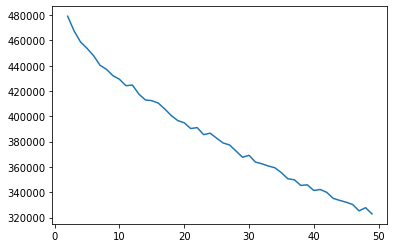

In [10]:
# elbow method to determine k

ks = list(range(2,50))
inertias = []

for k in ks:
    km = KMeans(n_clusters=k)
    km.fit(X_sc)
    print(k, 'sil', silhouette_score(X_sc, km.labels_))  # added in after plot did not show distinct point for k
    inertias.append(km.inertia_)
plt.plot(ks, inertias)

In [11]:
# very difficult to determine number for k based on this.  Maybe try 4, 32, 42, and 48 based on silhouette scores

In [12]:
km = KMeans(n_clusters=4, random_state=42)
km.fit(X_sc)

df['clusters'] = km.labels_

df.groupby('clusters').mean()[['saleprice', 'overall_qual']]  
# ^^^can look at different features in clusters and see how they compare

,saleprice,overall_qual
clusters,,
0,241873.214286,7.451613
1,243496.860104,7.132124
2,122898.934990,5.084130
3,153251.418571,5.480000


In [13]:
km = KMeans(n_clusters=32, random_state=42)
km.fit(X_sc)

df['clusters'] = km.labels_

df.groupby('clusters').mean().sort_values('saleprice', ascending=False)[['saleprice', 'overall_qual']]
# ^^^can look at different features in clusters and see how they compare

,saleprice,overall_qual
clusters,,
27,359166.500000,8.575000
7,355737.771429,8.571429
12,316906.765957,7.893617
22,264250.000000,7.250000
17,240815.988764,7.561798
0,225813.636364,8.000000
1,220743.789474,6.342105
25,217362.575000,6.868750
11,202135.463687,6.865922


In [14]:
km = KMeans(n_clusters=42, random_state=42)
km.fit(X_sc)

df['clusters'] = km.labels_

df.groupby('clusters').mean().sort_values('saleprice', ascending=False)[['saleprice', 'overall_qual']]
# ^^^can look at different features in clusters and see how they compare

,saleprice,overall_qual
clusters,,
27,390666.666667,10.000000
8,360564.152941,8.564706
2,339472.636364,8.212121
25,280000.000000,7.000000
0,264250.000000,7.250000
40,242495.912500,7.550000
4,213655.256637,6.884956
21,211734.425000,7.237500
7,211161.666667,5.833333


In [15]:
km = KMeans(n_clusters=48, random_state=42)
km.fit(X_sc)

df['clusters'] = km.labels_

df.groupby('clusters').mean().sort_values('saleprice', ascending=False)[['saleprice', 'bedroom_abvgr']]
# ^^^can look at different features in clusters and see how they compare

,saleprice,bedroom_abvgr
clusters,,
33,390666.666667,3.000000
21,365301.121622,2.594595
9,359251.258621,3.620690
15,313429.541667,3.562500
43,280000.000000,1.500000
13,258500.000000,2.000000
47,256666.666667,3.666667
38,251513.000000,1.892857
28,241500.000000,2.000000


---

## DBSCAN

In [16]:
features = [col for col in df._get_numeric_data().columns if col not in ['id', 'pid', 'saleprice']]
X = df[features]

In [17]:
# scale data
ss = StandardScaler()
X_sc = ss.fit_transform(X)

In [18]:
# search for best eps and min_samples
samples = list(range(2, 8))
epses = np.linspace(.05, 5.)

the_best = -999
for min_sample in samples:
    for eps in epses:
        try:
            dbscan = DBSCAN(eps=eps, min_samples=min_sample)
            dbscan.fit(X_sc)
            score = silhouette_score(X_sc, dbscan.labels_)
            # print(min_sample, eps, score)
            if score > the_best and set(dbscan.labels_) > 2:
                the_best = score
                print('best', min_sample, eps, score)
        except:
            continue

In [19]:
dbscan = DBSCAN(eps=8, min_samples=2)  # manually searching eps and min_samples since search didn't return any
dbscan.fit(X_sc)

DBSCAN(eps=8, min_samples=2)

In [20]:
set(dbscan.labels_)

{-1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99}

In [21]:
silhouette_score(X_sc, dbscan.labels_)

-0.16687767773643047

In [22]:
pd.Series(dbscan.labels_).value_counts(normalize=True)

-1     0.592756
 0     0.220754
 11    0.014195
 9     0.010768
 14    0.009300
         ...   
 61    0.000979
 63    0.000979
 66    0.000979
 68    0.000979
 50    0.000979
Length: 101, dtype: float64

In [23]:
# data doesn't seem to fit well into DBSCAN. Several datapoints continue to be labeled noise